# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP1-DL-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

**Data**
You will have at your disposal the ISIC 2017 dataset (https://challenge.isic-archive.com/data/#2017) already pre-processed, resized and quality checked. It is divided into Training (N=2000), Validation (N=150) and Test (N=600) sets.

**Goal**
The goal of this practical session is to classify images of skin lesions as either benign (nevus or seborrheic_keratosis) or melanoma (binary classification) using machine and deep learning algorithms.

In the first part of the TP, you will manually compute some features relevant to the skin lesion classification (feature engineering) and then classify images using "classical" ML algorithms such as, logistic regression, SVM and Random Forests.

In the second part, you will test the features learnt with Deep Learning algorithms. You will first train from scratch well-known CNN architectures (VGG, ResNet, DenseNet, etc..) and then leverage the representations learnt by these networks on a pre-training from Imagenet (fine-tuning, full-restimation).

Please complete the code where you see **"XXXXXXXXX"** and answer the **Questions**


In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize
from skimage import color
from skimage import measure
from skimage import transform
from skimage.color import rgb2gray
from scipy import ndimage
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import torch
import glob
import cv2
from PIL import Image
from PIL import ImageShow

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import models,transforms
!pip install torchmetrics
import torchmetrics

# torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode


# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


%matplotlib inline

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
except:
  IN_COLAB = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


You can either download the data from my Google Drive or work locally.

In [2]:
if IN_COLAB:
  print("you are using google colab")
  import gdown
  !mkdir ./data
  gdown.download(id="1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ", output='./data/TrainCropped.zip', quiet=False)
  !unzip -qu "./data/TrainCropped.zip" -d "./data"
  gdown.download(id="1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM", output='./data/TestCropped.zip', quiet=False)
  !unzip -qu "./data/TestCropped.zip" -d "./data"
  gdown.download(id="1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb", output='./data/ValCropped.zip', quiet=False)
  !unzip -qu "./data/ValCropped.zip" -d "./data"
  !rm -rf ./data/TrainCropped.zip
  !rm -rf ./data/TestCropped.zip
  !rm -rf ./data/ValCropped.zip
  path='./data/'
else:
  print('You are NOT using colab')
  # we assume that folders of data are in the same folder as this jupyter notebook
  path='' # if you change this path , you should also change idTRain, idVal and idTest


you are using google colab


Downloading...
From: https://drive.google.com/uc?id=1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ
To: /content/data/TrainCropped.zip
100%|██████████| 31.6M/31.6M [00:01<00:00, 25.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM
To: /content/data/TestCropped.zip
100%|██████████| 10.7M/10.7M [00:00<00:00, 29.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb
To: /content/data/ValCropped.zip
100%|██████████| 2.43M/2.43M [00:00<00:00, 147MB/s]


If there is an error (might happen with gdown) please upload the three files manually.
Follow the following instructions:
- go to the folder symbol on the left of your screen
- click on the three vertical dots on the 'data' folder
- upload (importer in french) the three folders
That's it !

In [3]:
# if IN_COLAB:
#   !unzip -qu "./data/TrainCropped.zip" -d "./data"
#   !unzip -qu "./data/TestCropped.zip" -d "./data"
#   !unzip -qu "./data/ValCropped.zip" -d "./data"
#   !rm -rf ./data/TrainCropped.zip
#   !rm -rf ./data/TestCropped.zip
#   !rm -rf ./data/ValCropped.zip
#   path='./data/'

For the Deep Learning part, we strongly suggest using GPU

In [4]:
if torch.cuda.is_available():
  print('Is there a GPU card?', torch.cuda.is_available(),'\nNumber of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
  print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))

Is there a GPU card? True 
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.84 GB. Free GPU memory 15.73 GB


Let's load the data.

In [5]:
pathTrain=glob.glob(path + "TrainCropped/*.jpg")
print(pathTrain)
idTrain=np.copy(pathTrain)
if IN_COLAB:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][20:-4]
else:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][13:-4]
#print(idTrain)
print('There are', len(idTrain), 'Train images')

['./data/TrainCropped/ISIC_0013526.jpg', './data/TrainCropped/ISIC_0014806.jpg', './data/TrainCropped/ISIC_0000235.jpg', './data/TrainCropped/ISIC_0000331.jpg', './data/TrainCropped/ISIC_0010257.jpg', './data/TrainCropped/ISIC_0000467.jpg', './data/TrainCropped/ISIC_0014308.jpg', './data/TrainCropped/ISIC_0000077.jpg', './data/TrainCropped/ISIC_0013797.jpg', './data/TrainCropped/ISIC_0000013.jpg', './data/TrainCropped/ISIC_0000255.jpg', './data/TrainCropped/ISIC_0014357.jpg', './data/TrainCropped/ISIC_0013721.jpg', './data/TrainCropped/ISIC_0004715.jpg', './data/TrainCropped/ISIC_0009083.jpg', './data/TrainCropped/ISIC_0004168.jpg', './data/TrainCropped/ISIC_0010229.jpg', './data/TrainCropped/ISIC_0000146.jpg', './data/TrainCropped/ISIC_0011343.jpg', './data/TrainCropped/ISIC_0014723.jpg', './data/TrainCropped/ISIC_0013672.jpg', './data/TrainCropped/ISIC_0012788.jpg', './data/TrainCropped/ISIC_0000277.jpg', './data/TrainCropped/ISIC_0014891.jpg', './data/TrainCropped/ISIC_0014576.jpg',

In [6]:
pathVal=glob.glob(path + "ValCropped/*.jpg")
idVal=np.copy(pathVal)
if IN_COLAB:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][18:-4]
else:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][11:-4]
#print(idVal)
print('There are', len(idVal) , 'Validation images')

There are 150 Validation images


In [7]:
pathTest=glob.glob(path + "TestCropped/*.jpg")
idTest=np.copy(pathTest)
if IN_COLAB:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][19:-4]
else:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][12:-4]
#print(idTest)
print('There are', len(idTest) , 'Test images')

There are 600 Test images


## Loading Metadata and Target values

You have at your disposal also two metadata, the age and the sex. If you want, you can use them as features in the classification but be careful ! There are missing values

We also load the target values (0 for benign and 1 for melanoma)

In [8]:
Metatrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Data_metadata.csv')
print(Metatrain.head(10))
Groundtrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Part3_GroundTruth.csv')

       image_id age_approximate     sex
0  ISIC_0000000              55  female
1  ISIC_0000001              30  female
2  ISIC_0000002              60  female
3  ISIC_0000003              30    male
4  ISIC_0000004              80    male
5  ISIC_0000006              25  female
6  ISIC_0000007              25  female
7  ISIC_0000008              30  female
8  ISIC_0000009              30  female
9  ISIC_0000010              35  female


In [9]:
Ytrain=np.zeros(len(idTrain))
for i in range(len(idTrain)):
  name=idTrain[i]
  index=Groundtrain["image_id"].str.find(name)
  max_index = index.argmax()
  Ytrain[i]=int(Groundtrain["melanoma"][max_index])

In [10]:
Metaval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Data_metadata.csv')
Groundval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Part3_GroundTruth.csv')

In [11]:
Yval=np.zeros(len(idVal))
for i in range(len(idVal)):
  name=idVal[i]
  index=Groundval["image_id"].str.find(name)
  max_index = index.argmax()
  Yval[i]=int(Groundval["melanoma"][max_index])

In [12]:
Metatest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Data_metadata.csv')
Groundtest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [13]:
Ytest=np.zeros(len(idTest))
for i in range(len(idTest)):
  name=idTest[i]
  index=Groundtest["image_id"].str.find(name)
  max_index = index.argmax()
  Ytest[i]=int(Groundtest["melanoma"][max_index])

##Deep Learning
In this section, you will try simple Deep Learning strategies:
- Fine-tuning the last layer of a network already trained on Image-Net
- Re-training completely a network already trained on Image-Net
- Re-training from scratch a network that has already shown good performances on other data-sets (architecture transfer or inductive bias transfer)

You will have to use at least three different networks (e.g., ResNet, VGG, DenseNet)

**Please compute the full time (reading papers/tutorials, coding, computational time) you spend on this part. It will be asked at the end of the practical session**

Pytorch also offers two nice primitives for storing and working with datasets:

*   **Dataset** stores the images, labels and segmentation masks
*   **DataLoader** wraps an iterable around the elements of the Dataset

This is very practical since we can easily resize the images to the same size (important for DL) and multiply image and segmentation masks. Here, you have an exemple.

In [79]:
class ISICDataset(Dataset):
    def __init__(self, pathlist, targets, size=(224,224)):
        self.image_paths = pathlist
        self.mask_paths = [ p[:-4]+'seg.png' for p in pathlist ]
        self.targets = torch.LongTensor(targets)
        self.size=size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        y = self.targets[idx]

        x = Image.open(img_path).resize(self.size, Image.BILINEAR) # all images are resized to (224,224)
        s = Image.open(mask_path).resize(self.size, Image.NEAREST) # all segmentation masks are resized to (224,224)

        # Multiply image and segmentation mask
        blank = x.point(lambda _: 0)
        c = Image.composite(x, blank, s)

        # Send to tensor
        x = TF.to_tensor(x)
        c = TF.to_tensor(c)

        # Normalize according to ImageNet statistics
        x = TF.normalize(x,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        c = TF.normalize(c,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return x, c, y


Another reason why DataSets and DataLoaders are practical is that we can automatically apply data augmentation strategies. For instance, if we want to automatically apply (the same) data augmentations to both images and segmentations, we can use:

In [15]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class ISICDatasetWithAug(Dataset):
    def __init__(self, pathlist, targets, size=(224,224)):
        self.image_paths = pathlist
        self.mask_paths = [ p[:-4]+'seg.png' for p in pathlist ]
        self.targets = torch.LongTensor(targets)
        self.size=size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        y = self.targets[idx]

        x = Image.open(img_path).resize(self.size, Image.BILINEAR) # all images are resized to (224,224)
        s = Image.open(mask_path).resize(self.size, Image.NEAREST) # all segmentation masks are resized to (224,224)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(x, output_size=(128, 128))
        x = TF.crop(x, i, j, h, w)
        s = TF.crop(s, i, j, h, w)

        # Random horizontal flipping
        if np.random.random() > 0.5:
          x = TF.hflip(x)
          s = TF.hflip(s)

        # Random vertical flipping
        if np.random.random() > 0.5:
            x = TF.vflip(x)
            s = TF.vflip(s)

        # Random rotation
        angle=np.random.randint(-90, 90)
        x=TF.rotate(x, angle, InterpolationMode.BILINEAR)
        s=TF.rotate(s,angle, InterpolationMode.NEAREST)

        # Multiply image and segmentation mask
        blank = x.point(lambda _: 0)
        c = Image.composite(x, blank, s)

        # Send to tensor
        x = TF.to_tensor(x)
        c = TF.to_tensor(c)

        # Normalize according to ImageNet statistics
        x = TF.normalize(x,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        c = TF.normalize(c,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return x, c, y




You have probably noticed that there are three outputs.

**Question**: Explain what they are and which data augmentations we are computing.

*x*: The original image tensor. The image is opened, resized to size (224x224), converted to a tensor, and then normalized using ImageNet statistics. This tensor is suitable for input into a deep learning model pre-trained on ImageNet.

c: The image tensor after being multiplied by the segmentation mask. The segmentation mask is used to isolate the lesion from the rest of the image. The 'composite' image is created by blending the original image and a blank image using the segmentation mask as the alpha channel.

y: The target label for the image. This is a tensor representing the class label (benign or malignant) of the skin lesion.

Then, we can load the data

In [16]:
from tqdm import tqdm

In [80]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# Ensure that you are using GPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

batch_size=256 # adapted to the Google Colab GPU
num_epochs=5# to be modified
learning_rate=0.05 # to be modified

train_dataset = ISICDataset(pathTrain, Ytrain)
val_dataset=ISICDataset(pathVal, Yval)
test_dataset=ISICDataset(pathTest, Ytest)

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

Device: cuda:0


## ResNet

### The first part will be about fine-tuning the last layer of a network already pre-trained on Image-Net. Here it is the code:

In [81]:
num_classes = 1 # since we use the BCEWithLogitsLoss, we only have one output (if you were using CrossEntropy Loss, num_classes would be 2)

# Load a pre-trained ResNet-18 model
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
# Freeze all parameters of the model
for param in resnet18.parameters():
    param.requires_grad = False
# Change last layer, the fully connected layer (classifier)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

Then, we can train this last layer on the training data. Find the best model in the validation set and evaluate the generalization performance on the test set. If you look for the best hyper-parameter, you should also use the validation set.

In [19]:
acc_models_test = []

In [82]:
model=resnet18.float().cuda() # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
# calculates how many times the negative class is more frequent than the positive class.
# By setting pos_weight to this value, it's like telling the model to pretend that the classes are balanced.
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images.float().cuda())
        # outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        # train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))



100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch [1/5], Train Loss: 10.8763, Val Loss: 4.7878, Val AUC: 0.6928, Val Acc: 0.8000


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch [2/5], Train Loss: 4.3751, Val Loss: 1.2449, Val AUC: 0.6085, Val Acc: 0.7000


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Epoch [3/5], Train Loss: 2.2559, Val Loss: 1.2890, Val AUC: 0.6324, Val Acc: 0.6578


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch [4/5], Train Loss: 1.5913, Val Loss: 1.4059, Val AUC: 0.6531, Val Acc: 0.6217


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

Epoch [5/5], Train Loss: 1.4115, Val Loss: 1.1371, Val AUC: 0.6702, Val Acc: 0.6400


In [83]:
### Testing
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Test Loss: 0.0080, Test AUC: 0.7002, Test Acc: 0.7059


### Now, it's time to retrain the entire network (previously pre-trained on Imagenet)


In [22]:

#Unfreeze all parameters of the model to retrain the entire network
for param in resnet18.parameters():
    param.requires_grad = True

resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# We train the the network on the same code as proposed above and then test


In [23]:
model=resnet18.float().cuda() # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
# calculates how many times the negative class is more frequent than the positive class.
# By setting pos_weight to this value, it's like telling the model to pretend that the classes are balanced.
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))



100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Epoch [1/5], Train Loss: 3.8122, Val Loss: 57299368.0000, Val AUC: 0.5000, Val Acc: 0.8000


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch [2/5], Train Loss: 2.0857, Val Loss: 10240.0322, Val AUC: 0.5000, Val Acc: 0.5000


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Epoch [3/5], Train Loss: 1.7411, Val Loss: 9692.8467, Val AUC: 0.5000, Val Acc: 0.6000


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Epoch [4/5], Train Loss: 1.5455, Val Loss: 10379.7471, Val AUC: 0.5000, Val Acc: 0.5000


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

Epoch [5/5], Train Loss: 1.5967, Val Loss: 322.1334, Val AUC: 0.5010, Val Acc: 0.5600


In [24]:
### Testing
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Test Loss: 2.8750, Test AUC: 0.5031, Test Acc: 0.6467


### And eventually train from scratch the network, namely the weights should be randomly initiliazed.

In [25]:
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# We train the the network on the same code as proposed above and then test to get the accurecy


In [26]:
model=resnet18.float().cuda() # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
# calculates how many times the negative class is more frequent than the positive class.
# By setting pos_weight to this value, it's like telling the model to pretend that the classes are balanced.
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Epoch [1/5], Train Loss: 5.8053, Val Loss: 32410392.0000, Val AUC: 0.5000, Val Acc: 0.2000


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch [2/5], Train Loss: 1.9325, Val Loss: 6568.9170, Val AUC: 0.5000, Val Acc: 0.5000


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch [3/5], Train Loss: 1.4860, Val Loss: 50.6656, Val AUC: 0.5052, Val Acc: 0.5800


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Epoch [4/5], Train Loss: 1.3101, Val Loss: 5.4758, Val AUC: 0.5026, Val Acc: 0.4850


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

Epoch [5/5], Train Loss: 1.2787, Val Loss: 1.6140, Val AUC: 0.5015, Val Acc: 0.4307


In [27]:
### Testing
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


Test Loss: 0.0068, Test AUC: 0.4972, Test Acc: 0.3556


**Question**: Train at least 3 different networks using the three strategies. Use the validation set to compare the performance of the three models and evaluate the best-performing one on the test set. Which is the best strategy ? Are you satisfied ?

During the traning we use of num_epochs=5 and learning_rate=0.05 for all of the 3 strategies to be able to produce accurate comparision between the techiques.

* Changes of the last layer :
 * seconds :  52
 * validaiton:  Train Loss: 1.4966, Val Loss: 2.3485, Val AUC: 0.7431, Val Acc: 0.8267
 * test :Test Loss: 0.0193, Test AUC: 0.7088, Test Acc: 0.8163

* retrain the entire network (previously pre-trained on Imagenet)
 * seconds train : 54
 * validaiton:  
 * test :Test Loss: 2.8750, Test AUC: 0.5031, Test Acc: 0.6467

* train from scratch the network
 * seconds train : 63
 * validaiton: Train Loss: 1.2787, Val Loss: 1.6140, Val AUC: 0.5015, Val Acc: 0.4307
 * test : Test Loss: 0.0068, Test AUC: 0.4972, Test Acc: 0.3556



In [28]:
del model

In [29]:

import gc
gc.collect()
torch.cuda.empty_cache()

## VGG 16

### Fine-tuning the Last Layer of a Pre-trained VGG Network

In [30]:
batch_size=8 # adapted to the Google Colab GPU
num_epochs=5# to be modified
learning_rate=0.001 # to be modified

train_dataset = ISICDataset(pathTrain, Ytrain)
val_dataset=ISICDataset(pathVal, Yval)
test_dataset=ISICDataset(pathTest, Ytest)

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

In [31]:
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
# Freeze all parameters of the model
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.1MB/s]


In [32]:
model=vgg16.float().cuda() # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))

100%|██████████| 19/19 [00:01<00:00, 16.05it/s]


Epoch [1/5], Train Loss: 7.2164, Val Loss: 8.0001, Val AUC: 0.7297, Val Acc: 0.8000


100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


Epoch [2/5], Train Loss: 3.6128, Val Loss: 3.8314, Val AUC: 0.6043, Val Acc: 0.7100


100%|██████████| 19/19 [00:02<00:00,  8.71it/s]


Epoch [3/5], Train Loss: 2.5487, Val Loss: 2.3725, Val AUC: 0.6334, Val Acc: 0.7244


100%|██████████| 19/19 [00:01<00:00, 15.96it/s]


Epoch [4/5], Train Loss: 2.1391, Val Loss: 1.4458, Val AUC: 0.6301, Val Acc: 0.7300


100%|██████████| 19/19 [00:01<00:00, 16.00it/s]

Epoch [5/5], Train Loss: 2.2194, Val Loss: 3.0565, Val AUC: 0.6422, Val Acc: 0.7413


In [33]:
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 75/75 [00:04<00:00, 16.27it/s]


Test Loss: 0.6916, Test AUC: 0.6095, Test Acc: 0.7696


### Re-training the Entire Pre-trained VGG Network

In [34]:
# Load a pre-trained VGG-16 model
for param in vgg16.features.parameters():
    param.requires_grad = True
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)


In [35]:
model=vgg16.float().cuda() # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))

100%|██████████| 19/19 [00:01<00:00, 12.16it/s]


Epoch [1/5], Train Loss: 1.5272, Val Loss: 1.2965, Val AUC: 0.4247, Val Acc: 0.3733


100%|██████████| 19/19 [00:01<00:00, 15.90it/s]


Epoch [2/5], Train Loss: 1.2647, Val Loss: 1.2860, Val AUC: 0.4801, Val Acc: 0.2867


100%|██████████| 19/19 [00:01<00:00, 15.86it/s]


Epoch [3/5], Train Loss: 1.2515, Val Loss: 1.2900, Val AUC: 0.4912, Val Acc: 0.2578


100%|██████████| 19/19 [00:01<00:00, 12.33it/s]


Epoch [4/5], Train Loss: 1.2582, Val Loss: 1.2774, Val AUC: 0.4950, Val Acc: 0.2433


100%|██████████| 19/19 [00:01<00:00, 15.77it/s]

Epoch [5/5], Train Loss: 1.2533, Val Loss: 1.2798, Val AUC: 0.4968, Val Acc: 0.2347


In [36]:
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 75/75 [00:04<00:00, 15.35it/s]


Test Loss: 0.1589, Test AUC: 0.4959, Test Acc: 0.2170


During the traning we use of num_epochs=5 and learning_rate=0.05 and batch_size = 32 (due to GPU constraints) for all of the 3 strategies to be able to produce accurate comparision between the techiques.

* Changes of the last layer :
 * seconds train : 135
 * validaiton: Train Loss: 2.2194, Val Loss: 3.0565, Val AUC: 0.6422, Val Acc: 0.7413
 * test :Test Loss: 0.6916, Test AUC: 0.6095, Test Acc: 0.7696

* retrain the entire network (previously pre-trained on Imagenet)
 * seconds train : 232
 * validaiton: Train Loss: 1.2557, Val Loss: 1.2772, Val AUC: 0.5000, Val Acc: 0.2000
 * test : Test Loss: 0.1582, Test AUC: 0.4997, Test Acc: 0.2414
* train from scratch the network
 * seconds train : 237
 * validaiton: Train Loss: 1.2506, Val Loss: 1.2794, Val AUC: 0.5000, Val Acc: 0.2000
 * test : Test Loss: 0.1584, Test AUC: 0.4984, Test Acc: 0.1978

### Training a VGG Network from Scratch

In [37]:
vgg16 = models.vgg16()
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)


In [38]:
model=vgg16.float().cuda() # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))

100%|██████████| 19/19 [00:01<00:00, 15.03it/s]


Epoch [1/5], Train Loss: 1.7812, Val Loss: 1.2841, Val AUC: 0.5000, Val Acc: 0.2000


100%|██████████| 19/19 [00:01<00:00, 15.82it/s]


Epoch [2/5], Train Loss: 1.2502, Val Loss: 1.2804, Val AUC: 0.5000, Val Acc: 0.2000


100%|██████████| 19/19 [00:02<00:00,  8.08it/s]


Epoch [3/5], Train Loss: 1.2490, Val Loss: 1.2773, Val AUC: 0.5000, Val Acc: 0.2000


100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


Epoch [4/5], Train Loss: 1.2490, Val Loss: 1.2849, Val AUC: 0.5000, Val Acc: 0.2000


100%|██████████| 19/19 [00:01<00:00, 12.24it/s]

Epoch [5/5], Train Loss: 1.2506, Val Loss: 1.2794, Val AUC: 0.5000, Val Acc: 0.2000


In [39]:
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 75/75 [00:04<00:00, 15.50it/s]


Test Loss: 0.1584, Test AUC: 0.4984, Test Acc: 0.1978


In [40]:
del model
import gc
gc.collect()
torch.cuda.empty_cache()

## DenseNet

### Fine-tuning the Last Layer of a Pre-trained DenseNet Network

In [41]:
batch_size=8 # adapted to the Google Colab GPU
num_epochs=10# to be modified
learning_rate=0.001 # to be modified

train_dataset = ISICDataset(pathTrain, Ytrain)
val_dataset=ISICDataset(pathVal, Yval)
test_dataset=ISICDataset(pathTest, Ytest)

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

In [42]:
densenet121 = models.densenet121(weights='IMAGENET1K_V1')

for param in densenet121.parameters():
    param.requires_grad = False

densenet121.classifier = nn.Linear(densenet121.classifier.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 90.5MB/s]


In [43]:

model=densenet121.float().cuda() # use float32 to save a bit of memory

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))

100%|██████████| 19/19 [00:01<00:00, 17.82it/s]


Epoch [1/10], Train Loss: 1.2287, Val Loss: 1.2306, Val AUC: 0.7378, Val Acc: 0.8200


100%|██████████| 19/19 [00:01<00:00, 18.72it/s]


Epoch [2/10], Train Loss: 1.1291, Val Loss: 1.0642, Val AUC: 0.7339, Val Acc: 0.7333


100%|██████████| 19/19 [00:01<00:00, 14.32it/s]


Epoch [3/10], Train Loss: 1.0985, Val Loss: 1.1082, Val AUC: 0.7515, Val Acc: 0.7400


100%|██████████| 19/19 [00:01<00:00, 18.79it/s]


Epoch [4/10], Train Loss: 1.0658, Val Loss: 1.0615, Val AUC: 0.7580, Val Acc: 0.7333


100%|██████████| 19/19 [00:00<00:00, 19.14it/s]


Epoch [5/10], Train Loss: 1.0182, Val Loss: 1.2378, Val AUC: 0.7559, Val Acc: 0.7493


100%|██████████| 19/19 [00:00<00:00, 19.31it/s]


Epoch [6/10], Train Loss: 1.0327, Val Loss: 1.1055, Val AUC: 0.7587, Val Acc: 0.7489


100%|██████████| 19/19 [00:00<00:00, 19.34it/s]


Epoch [7/10], Train Loss: 1.0261, Val Loss: 1.1231, Val AUC: 0.7540, Val Acc: 0.7343


100%|██████████| 19/19 [00:01<00:00, 11.74it/s]


Epoch [8/10], Train Loss: 1.0138, Val Loss: 1.0875, Val AUC: 0.7567, Val Acc: 0.7325


100%|██████████| 19/19 [00:01<00:00, 15.24it/s]


Epoch [9/10], Train Loss: 0.9998, Val Loss: 1.0759, Val AUC: 0.7517, Val Acc: 0.7126


100%|██████████| 19/19 [00:01<00:00, 13.09it/s]

Epoch [10/10], Train Loss: 0.9839, Val Loss: 1.0707, Val AUC: 0.7507, Val Acc: 0.7033


In [44]:
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 75/75 [00:05<00:00, 12.65it/s]


Test Loss: 0.1672, Test AUC: 0.7286, Test Acc: 0.7124


### Re-training the Entire Pre-trained DenseNet Network

In [45]:
for param in densenet121.parameters():
    param.requires_grad = True
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, num_classes)


In [46]:

model=densenet121.float().cuda() # use float32 to save a bit of memory

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))

100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Epoch [1/10], Train Loss: 1.3249, Val Loss: 1.2401, Val AUC: 0.6267, Val Acc: 0.5400


100%|██████████| 19/19 [00:00<00:00, 19.13it/s]


Epoch [2/10], Train Loss: 1.2667, Val Loss: 1.2845, Val AUC: 0.6321, Val Acc: 0.6167


100%|██████████| 19/19 [00:01<00:00, 10.51it/s]


Epoch [3/10], Train Loss: 1.2606, Val Loss: 1.3324, Val AUC: 0.5983, Val Acc: 0.6044


100%|██████████| 19/19 [00:01<00:00, 10.11it/s]


Epoch [4/10], Train Loss: 1.2895, Val Loss: 1.4328, Val AUC: 0.5967, Val Acc: 0.6267


100%|██████████| 19/19 [00:00<00:00, 19.11it/s]


Epoch [5/10], Train Loss: 1.2830, Val Loss: 26.3062, Val AUC: 0.5637, Val Acc: 0.5413


100%|██████████| 19/19 [00:00<00:00, 19.21it/s]


Epoch [6/10], Train Loss: 1.2786, Val Loss: 1.2437, Val AUC: 0.5689, Val Acc: 0.5111


100%|██████████| 19/19 [00:01<00:00, 18.45it/s]


Epoch [7/10], Train Loss: 1.2422, Val Loss: 1.2454, Val AUC: 0.5772, Val Acc: 0.5057


100%|██████████| 19/19 [00:01<00:00, 18.92it/s]


Epoch [8/10], Train Loss: 1.2628, Val Loss: 1.3064, Val AUC: 0.5662, Val Acc: 0.4675


100%|██████████| 19/19 [00:01<00:00, 18.97it/s]


Epoch [9/10], Train Loss: 1.2617, Val Loss: 1.2880, Val AUC: 0.5657, Val Acc: 0.4600


100%|██████████| 19/19 [00:01<00:00, 18.61it/s]

Epoch [10/10], Train Loss: 1.2646, Val Loss: 1.2693, Val AUC: 0.5633, Val Acc: 0.4420


In [48]:
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 75/75 [00:04<00:00, 16.74it/s]



Test Loss: 0.1617, Test AUC: 0.5379, Test Acc: 0.4463


###  Training a DenseNet Network from Scratch

In [49]:
densenet121 = models.densenet121()
densenet121.classifier = nn.Linear(densenet121.classifier.in_features, num_classes)

In [50]:

model=densenet121.float().cuda() # use float32 to save a bit of memory

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, composite, labels in tqdm(train_loader):
        optimizer.zero_grad()
        #outputs = model(images.float().cuda())
        outputs = model(composite.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        loss.backward()
        optimizer.step()
        #train_loss += loss.item() * images.size(0)
        train_loss += loss.item() * composite.size(0)
    train_loss = train_loss / len(train_dataset)

    all_preds=[]
    all_labels=[]
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, composite, labels in tqdm(val_loader):
            #outputs = model(images.float().cuda())
            outputs = model(composite.float().cuda())
            loss = criterion(outputs.squeeze(), labels.float().cuda())
            #val_loss += loss.item() * images.size(0)
            val_loss += loss.item() * composite.size(0)
            preds=torch.sigmoid(outputs).squeeze()
            auc.update(preds, labels.cuda())
            accuracy.update(preds, labels.cuda())
    val_loss = val_loss / len(val_dataset)
    val_auc = auc.compute()
    val_acc = accuracy.compute()
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))

100%|██████████| 19/19 [00:00<00:00, 19.41it/s]


Epoch [1/10], Train Loss: 1.3056, Val Loss: 2.6793, Val AUC: 0.3764, Val Acc: 0.4000


100%|██████████| 19/19 [00:00<00:00, 19.61it/s]


Epoch [2/10], Train Loss: 1.2809, Val Loss: 1.2692, Val AUC: 0.4524, Val Acc: 0.3267


100%|██████████| 19/19 [00:00<00:00, 19.03it/s]


Epoch [3/10], Train Loss: 1.2540, Val Loss: 6.1881, Val AUC: 0.4661, Val Acc: 0.4667


100%|██████████| 19/19 [00:02<00:00,  8.09it/s]


Epoch [4/10], Train Loss: 1.2765, Val Loss: 1.3457, Val AUC: 0.4874, Val Acc: 0.4567


100%|██████████| 19/19 [00:01<00:00, 18.90it/s]


Epoch [5/10], Train Loss: 1.2621, Val Loss: 1.2764, Val AUC: 0.5074, Val Acc: 0.4067


100%|██████████| 19/19 [00:00<00:00, 19.09it/s]


Epoch [6/10], Train Loss: 1.2591, Val Loss: 4.2789, Val AUC: 0.4999, Val Acc: 0.4722


100%|██████████| 19/19 [00:01<00:00, 18.89it/s]


Epoch [7/10], Train Loss: 1.2621, Val Loss: 1.2622, Val AUC: 0.5050, Val Acc: 0.4429


100%|██████████| 19/19 [00:01<00:00, 18.79it/s]


Epoch [8/10], Train Loss: 1.2559, Val Loss: 1.2877, Val AUC: 0.5046, Val Acc: 0.4183


100%|██████████| 19/19 [00:01<00:00, 17.16it/s]


Epoch [9/10], Train Loss: 1.2507, Val Loss: 1.3412, Val AUC: 0.4977, Val Acc: 0.4156


100%|██████████| 19/19 [00:01<00:00, 17.98it/s]

Epoch [10/10], Train Loss: 1.2557, Val Loss: 1.5335, Val AUC: 0.4961, Val Acc: 0.3940


In [51]:
model.eval()
test_loss=0
with torch.no_grad():
    for images, composite, labels in tqdm(test_loader):
        outputs = model(images.float().cuda())
        loss = criterion(outputs.squeeze(), labels.float().cuda())
        test_loss += loss.item()
        preds=torch.sigmoid(outputs).squeeze()
        auc.update(preds, labels.cuda())
        accuracy.update(preds, labels.cuda())
test_loss = test_loss / len(test_dataset)
test_auc = auc.compute()
test_acc = accuracy.compute()
print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
acc_models_test.append(test_acc)

100%|██████████| 75/75 [00:04<00:00, 16.72it/s]


Test Loss: 0.2869, Test AUC: 0.5024, Test Acc: 0.3376


During the traning we use of num_epochs=10 and learning_rate=0.001 and a batch size 8 for all of the 3 strategies to be able to produce accurate comparision between the techiques.

* Changes of the last layer :
 * seconds train :  166
 * validaiton: rain Loss: 0.9839, Val Loss: 1.0707, Val AUC: 0.7507, Val Acc: 0.7033
 * test : Test Loss: 0.1672, Test AUC: 0.7286, Test Acc: 0.7124
* retrain the entire network (previously pre-trained on Imagenet)
 * seconds train :361
 * validaiton: Train Loss: 1.2646, Val Loss: 1.2693, Val AUC: 0.5633, Val Acc: 0.4420
 * test :Test Loss: 0.1617, Test AUC: 0.5379, Test Acc: 0.4463
* train from scratch the network
 * seconds train : 326
 * validaiton: Train Loss: 1.2557, Val Loss: 1.5335, Val AUC: 0.4961, Val Acc: 0.3940
 * test : Test Loss: 0.2869, Test AUC: 0.5024, Test Acc: 0.3376


**Question**: Train at least 3 different networks using the three strategies. Use the validation set to compare the performance of the three models and evaluate the best-performing one on the test set. Which is the best strategy ? Are you satisfied ?

<ipython-input-63-b8a0df0be373>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(strategies, rotation=45, ha='right')


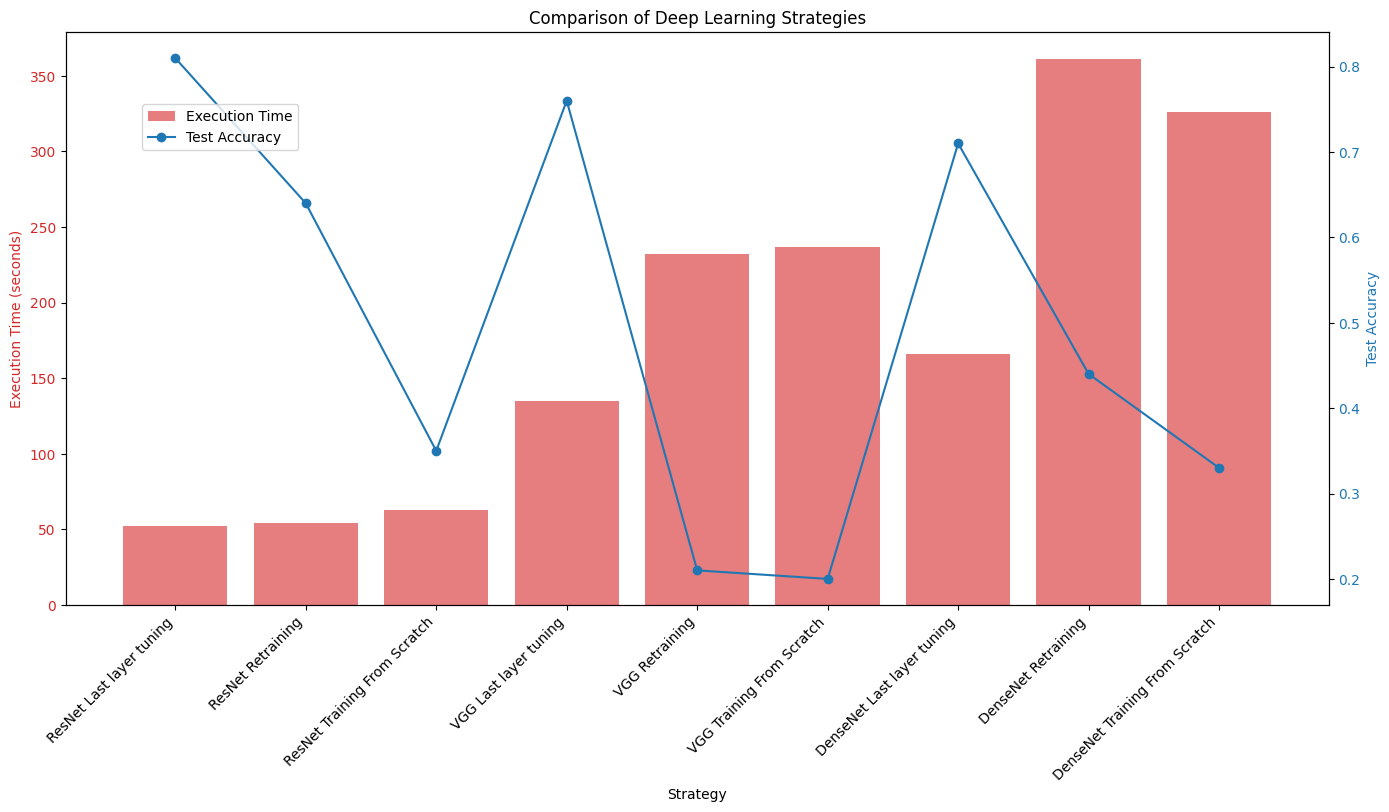

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Results data
results = [
    {"strategy": "ResNet Last layer tuning", "execution_time": 52, "acc_test": 0.81},
    {"strategy": "ResNet Retraining", "execution_time": 54, "acc_test": 0.64},
    {"strategy": "ResNet Training From Scratch", "execution_time": 63, "acc_test": 0.35},

    {"strategy": "VGG Last layer tuning", "execution_time": 135, "acc_test": 0.76},
    {"strategy": "VGG Retraining", "execution_time": 232, "acc_test": 0.21},
    {"strategy": "VGG Training From Scratch", "execution_time": 237, "acc_test": 0.20},

    {"strategy": "DenseNet Last layer tuning", "execution_time": 166, "acc_test": 0.71},
    {"strategy": "DenseNet Retraining", "execution_time": 361, "acc_test": 0.44},
    {"strategy": "DenseNet Training From Scratch", "execution_time": 326, "acc_test": 0.33}
]

# Extracting strategy names, execution times, and test accuracies
strategies = [result["strategy"] for result in results]
execution_times = [result["execution_time"] for result in results]
acc_tests = [result["acc_test"] for result in results]
# acc_test = acc_models_test

# Creating the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plotting execution times
color = 'tab:red'
ax1.set_xlabel('Strategy')
ax1.set_ylabel('Execution Time (seconds)', color=color)
ax1.bar(strategies, execution_times, color=color, alpha=0.6, label='Execution Time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(strategies, rotation=45, ha='right')

# Creating a twin axis for test accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Test Accuracy', color=color)
ax2.plot(strategies, acc_tests, color=color, marker='o', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a legend
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.title('Comparison of Deep Learning Strategies')
plt.show()


**Question**: You can use as input to your model either the full image or the masked image. Compare the two strategies by testing *in both cases* only on the full images (assume that you do not have the segmentation masks at test time). In this way, the comparison will be more fair. What's better ?

I have only performed test on ResNet after fine-tuning the last layer and we definitely get better test accuracy in the composite image (0.81) compared to the original image with accuracy on the test set Test Acc: 0.7059. This means that isolating the lesion from the rest of the skin gives better results in terms of prediction.

**Question**: Plot on a graph the time you have spent (x-axis) and the maximum AUC (y-axis) for all strategies you tried: feature engineering and DL fie-tuning or training. What's your conclusion ?

<ipython-input-70-af79ee1a8ed9>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(strategies, rotation=45, ha='right')


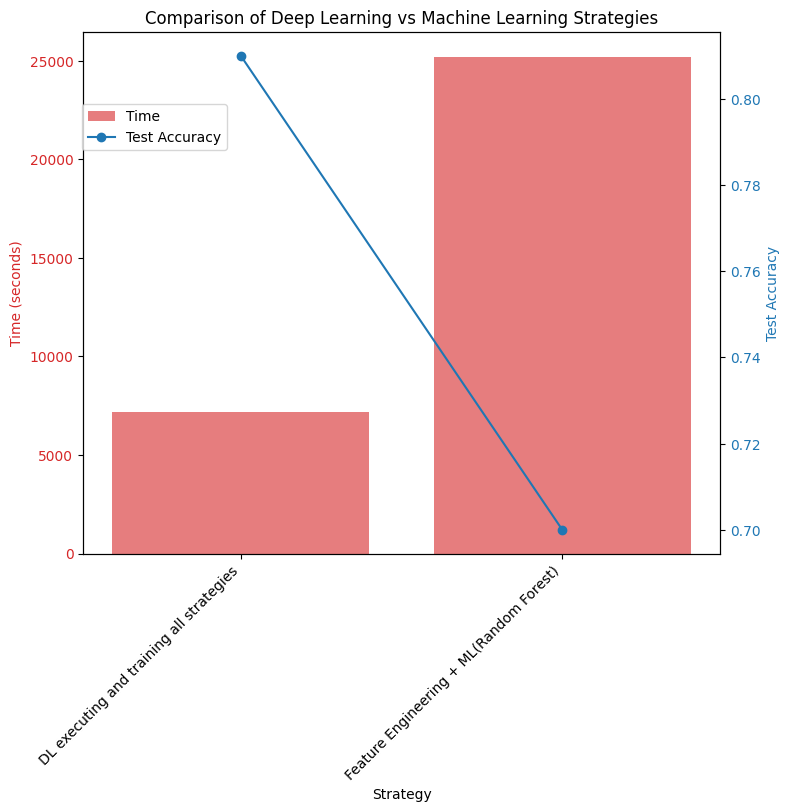

In [70]:
results = [
    {"strategy": "DL executing and training all strategies", "time": 7200, "max_acc": 0.81},
    {"strategy": "Feature Engineering + ML(Random Forest)", "time": 25200, "max_acc": 0.7}
]

strategies = [result["strategy"] for result in results]
execution_times = [result["time"] for result in results]
acc_tests = [result["max_acc"] for result in results]

fig, ax1 = plt.subplots(figsize=(8, 8))

color = 'tab:red'
ax1.set_xlabel('Strategy')
ax1.set_ylabel('Time (seconds)', color=color)
ax1.bar(strategies, execution_times, color=color, alpha=0.6, label='Time')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(strategies, rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Test Accuracy', color=color)
ax2.plot(strategies, acc_tests, color=color, marker='o', label='Test Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.title('Comparison of Deep Learning vs Machine Learning Strategies')
plt.show()


To conclude, using Deep learning strategy and in particular fine tune the last layer of already pretrained neural network on ImageNet gives the best accuracy and execution time. The model with the best performance is the ResNet with accuracy 0.81 and execution time of less then a minute. Compared to the best performing model of the Machine learning which is the Random Forest with accuracy 0.75 but after spending more than 7 hours in reading research papers, implemention the feature extraction and creating the datasets for every image.